In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [18]:
from models.bayesian_neural_network.bayesian_linear import BNNConfig

cfg = BNNConfig(
    prior_sigma=1.0,
    observed_sigma=0.1,
    hidden_dim=64,
    epochs=500,
    batch_size=128,
    lr=0.001,
    mc_train_samples=10,
    mc_test_samples=100,
    device='mps'
)

In [ ]:
torch.manual_seed(42)
device = torch.device(cfg.device)

# Toy data: y = sin(x) + ε; remove a region to induce epistemic uncertainty
n_train, n_test = 512, 256
x_train = torch.linspace(-3.0, 3.0, n_train).unsqueeze(1)
y_train = torch.sin(x_train) + 0.2 * torch.randn_like(x_train)
mask = ~((x_train[:, 0] > 0.5) & (x_train[:, 0] < 1.5))
x_train, y_train = x_train[mask], y_train[mask]

x_test = torch.linspace(-4.0, 4.0, n_test).unsqueeze(1)
y_test = torch.sin(x_test)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)

In [10]:
from models.bayesian_neural_network.bayesian_mlp import BayesianMLP
from models.bayesian_neural_network.elbo_regression import elbo_regression

model = BayesianMLP(1, cfg.hidden_dim, 1, cfg.prior_sigma).to(device)
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

n_batches = len(train_loader)
for epoch in range(1, cfg.epochs + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = elbo_regression(model, xb, yb, cfg.observed_sigma, n_batches, cfg.mc_train_samples)
        loss.backward()
        opt.step()
        total += loss.item()
    if epoch % 100 == 0:
        print(f"[{epoch:04d}] ELBO≈ {total / n_batches:.4f}")

[0100] ELBO≈ 1573.6380


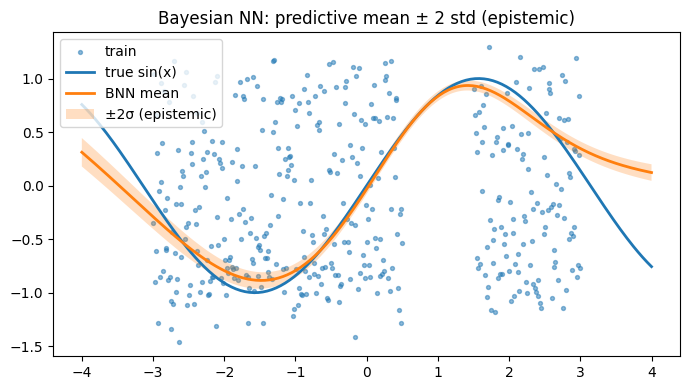

In [11]:
import matplotlib.pyplot as plt

# Create graph
model.eval()
preds = []
xt = torch.cat([b[0] for b in test_loader], dim=0).to(device)
yt = torch.cat([b[1] for b in test_loader], dim=0).to(device)

for _ in range(cfg.mc_test_samples):
    mu, _ = model(xt.to(device), sample=True)
    preds.append(mu)

P = torch.stack(preds, dim=0)           # [S, N, 1]
mean = P.mean(dim=0).squeeze(1).detach()         # [N]
std  = P.std(dim=0).squeeze(1).detach()          # [N] epistemic uncertainty

plt.figure(figsize=(7, 4))
xtr = torch.cat([b[0] for b in train_loader], dim=0)
ytr = torch.cat([b[1] for b in train_loader], dim=0)
plt.scatter(xtr.cpu(), ytr.cpu(), s=8, alpha=0.5, label="train")
plt.plot(xt.cpu(), yt.cpu(), linewidth=2, label="true sin(x)")
plt.plot(xt.cpu(), mean.cpu(), linewidth=2, label="BNN mean")
plt.fill_between(
    xt.squeeze(1).cpu(),
    (mean - 2 * std).cpu(),
    (mean + 2 * std).cpu(),
    alpha=0.25,
    label="±2σ (epistemic)"
)
plt.title("Bayesian NN: predictive mean ± 2 std (epistemic)")
plt.legend()
plt.tight_layout()
plt.show()

[Noise σ=0.0] Epoch 050 | ELBO=1662.4650
[Noise σ=0.0] Epoch 100 | ELBO=1571.7737
[Noise σ=0.5] Epoch 050 | ELBO=1666.3071
[Noise σ=0.5] Epoch 100 | ELBO=1577.9310
[Noise σ=0.9] Epoch 050 | ELBO=1677.1939
[Noise σ=0.9] Epoch 100 | ELBO=1587.6381


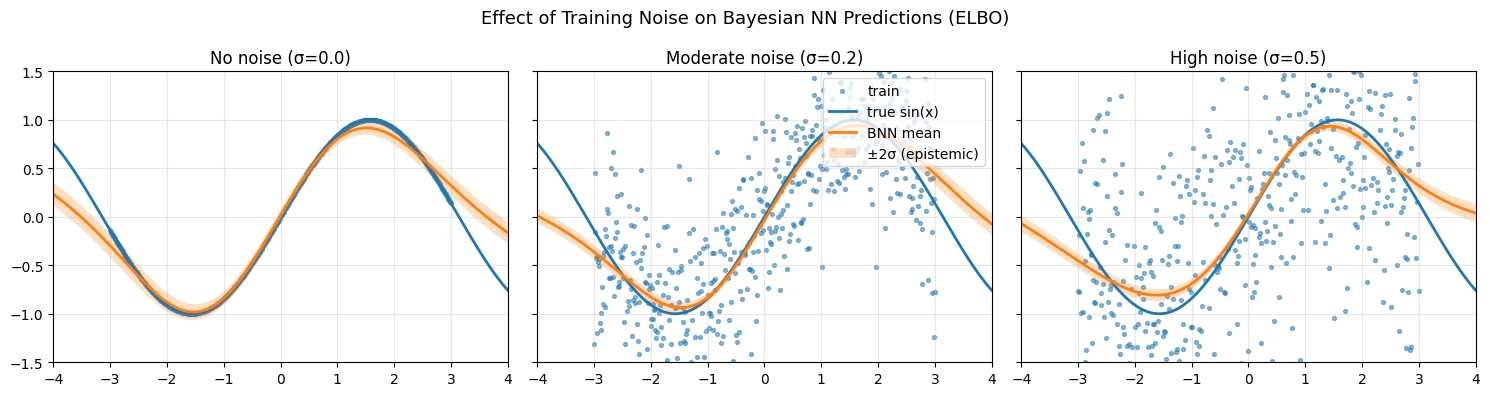

In [14]:
# --- Experiment setup ---
noise_levels = [0.0, 0.5, 0.9]
titles = ["No noise (σ=0.0)", "Moderate noise (σ=0.2)", "High noise (σ=0.5)"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, noise in enumerate(noise_levels):
    # --- 1. Generate training data ---
    n_train, n_test = 512, 256
    x_train = torch.linspace(-3.0, 3.0, n_train).unsqueeze(1)
    y_train = torch.sin(x_train) + noise * torch.randn_like(x_train)

    x_test = torch.linspace(-4.0, 4.0, n_test).unsqueeze(1)
    y_test = torch.sin(x_test)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=True)
    n_batches = len(train_loader)

    # --- 2. Reinitialize and retrain the model ---
    model = BayesianMLP(1, cfg.hidden_dim, 1, cfg.prior_sigma).to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    model.train()

    for epoch in range(cfg.epochs):
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(cfg.device), yb.to(cfg.device)
            optimizer.zero_grad()
            loss = elbo_regression(model, xb, yb, cfg.observed_sigma, n_batches, cfg.mc_train_samples)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 50 == 0:
            print(f"[Noise σ={noise}] Epoch {epoch+1:03d} | ELBO={total_loss/n_batches:.4f}")

    # --- 3. Evaluate (same as before) ---
    model.eval()
    preds = []
    for _ in range(cfg.mc_test_samples):
        mu, _ = model(x_test.to(cfg.device), sample=True)
        preds.append(mu)
    P = torch.stack(preds, dim=0)
    mean = P.mean(dim=0).squeeze(1).detach()
    std = P.std(dim=0).squeeze(1).detach()

    # --- 4. Plot ---
    ax = axes[i]
    ax.scatter(x_train.cpu(), y_train.cpu(), s=8, alpha=0.5, label="train")
    ax.plot(x_test.cpu(), y_test.cpu(), linewidth=2, label="true sin(x)")
    ax.plot(x_test.cpu(), mean.cpu(), linewidth=2, label="BNN mean")
    ax.fill_between(
        x_test.squeeze(1).cpu(),
        (mean - 2 * std).cpu(),
        (mean + 2 * std).cpu(),
        alpha=0.25,
        label="±2σ (epistemic)"
    )
    ax.set_title(titles[i])
    ax.set_xlim(-4, 4)
    ax.set_ylim(-1.5, 1.5)
    ax.grid(alpha=0.3)

axes[1].legend(loc="upper right")
fig.suptitle("Effect of Training Noise on Bayesian NN Predictions (ELBO)", fontsize=13)
plt.tight_layout()
plt.show()

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
device = torch.device(cfg.device)

# --- 1. Configuration ---
n_train, n_test = 512, 256
x_train = torch.linspace(-3.0, 3.0, n_train).unsqueeze(1)
x_test  = torch.linspace(-4.0, 4.0, n_test).unsqueeze(1)

# --- 2. Generate stochastic drift and volatility ---
def generate_financial_signal(x):
    # base drift term
    drift = 0.3 * x
    
    # stochastic volatility component
    vol_noise = torch.randn_like(x) * 0.1
    ar_vol = torch.zeros_like(x)
    for i in range(1, len(x)):
        ar_vol[i] = 0.8 * ar_vol[i-1] + vol_noise[i]
    sigma = 0.2 + 0.3 * torch.sin(0.5 * x) + 0.4 * ar_vol
    sigma = sigma.abs()  # ensure positive volatility

    # base pattern (sinusoidal + drift)
    base_signal = torch.sin(x) + drift

    # noise term (heteroskedastic)
    y = base_signal + sigma * torch.randn_like(x)
    return y, sigma

y_train, sigma_train = generate_financial_signal(x_train)
y_test,  sigma_test  = generate_financial_signal(x_test)

# --- 3. Remove region to induce epistemic gap (no training data between 0.5–1.5) ---
mask = ~((x_train[:, 0] > 0.5) & (x_train[:, 0] < 1.5))
x_train, y_train = x_train[mask], y_train[mask]

# --- 4. Build dataloaders ---
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=cfg.batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test, y_test), batch_size=cfg.batch_size, shuffle=False)

In [20]:
from models.bayesian_neural_network.bayesian_mlp import BayesianMLP
from models.bayesian_neural_network.elbo_regression import elbo_regression

model = BayesianMLP(1, cfg.hidden_dim, 1, cfg.prior_sigma).to(device)
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

n_batches = len(train_loader)
for epoch in range(1, cfg.epochs + 1):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = elbo_regression(model, xb, yb, cfg.observed_sigma, n_batches, cfg.mc_train_samples)
        loss.backward()
        opt.step()
        total += loss.item()
    if epoch % 100 == 0:
        print(f"[{epoch:04d}] ELBO≈ {total / n_batches:.4f}")

[0100] ELBO≈ 1573.6823
[0200] ELBO≈ 1404.3593
[0300] ELBO≈ 1233.3685
[0400] ELBO≈ 1066.1079
[0500] ELBO≈ 900.9454


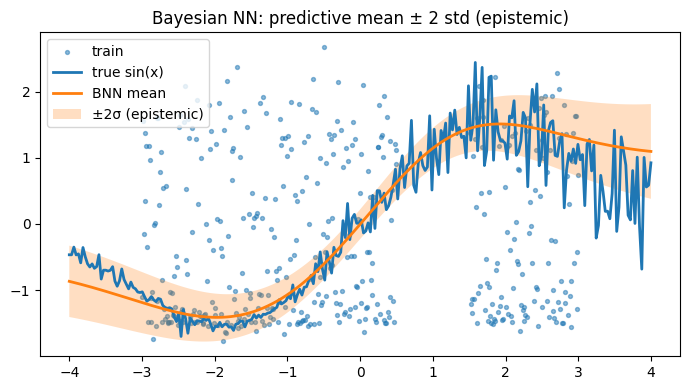

In [22]:
import matplotlib.pyplot as plt

# Create graph
model.eval()
preds = []
xt = torch.cat([b[0] for b in test_loader], dim=0).to(device)
yt = torch.cat([b[1] for b in test_loader], dim=0).to(device)

for _ in range(cfg.mc_test_samples):
    mu, _ = model(xt.to(device), sample=True)
    preds.append(mu)

P = torch.stack(preds, dim=0)           # [S, N, 1]
mean = P.mean(dim=0).squeeze(1).detach()         # [N]
std  = P.std(dim=0).squeeze(1).detach()          # [N] epistemic uncertainty

plt.figure(figsize=(7, 4))
xtr = torch.cat([b[0] for b in train_loader], dim=0)
ytr = torch.cat([b[1] for b in train_loader], dim=0)
plt.scatter(xtr.cpu(), ytr.cpu(), s=8, alpha=0.5, label="train")
plt.plot(xt.cpu(), yt.cpu(), linewidth=2, label="true sin(x)")
plt.plot(xt.cpu(), mean.cpu(), linewidth=2, label="BNN mean")
plt.fill_between(
    xt.squeeze(1).cpu(),
    (mean - 2 * std).cpu(),
    (mean + 2 * std).cpu(),
    alpha=0.25,
    label="±2σ (epistemic)"
)
plt.title("Bayesian NN: predictive mean ± 2 std (epistemic)")
plt.legend()
plt.tight_layout()
plt.show()